In [33]:
from extraction.extract import *
from math import *
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from datetime import datetime

DATA PREPARATION

In [34]:
print(dataset.dtypes)
print(len(dataset.columns))

departing                     int64
arriving                      int64
lowcost                     float64
arrivalsFlightDuration      float64
arrivalsDepartureDelay      float64
arrivalsArrivalDelay        float64
departuresFlightDuration    float64
departuresArrivalDelay      float64
planes                        int64
capacityFilled              float64
weekend                       int64
winter                        int64
spring                        int64
summer                        int64
autumn                        int64
night                         int64
morning                       int64
afternoon                     int64
evening                       int64
departuresDepartureDelay    float64
dtype: object
20


In [35]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



dataset = generateNNdata("EHAM", timeslotLength=15, catagoricalFlightDuration=False)
dataset = dataset.set_index("timeslot")

# dataset.columns = [
#     "departing",
#     "arriving",
#     "lowcost",
#     "arrivalsFlightDuration",
#     "departuresFlightDuration",
#     "planes",
#     "weekend",
#     "winter",
#     "spring",
#     "summer",
#     "autumn",
#     "night",
#     "morning",
#     "afternoon",
#     "evening",
# 	# "arrivalsArrivalDelay",
# 	"departuresDepartureDelay"
# ]

dataset.drop(columns=['departuresArrivalDelay','arrivalsArrivalDelay'])
label = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label)

# Get first month of Data
number_of_months = 1
index_slice = number_of_months * 4 * 24 * 31 - 1
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
display(dataset)

# Normalize values
values = dataset.values
display(values)

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# display(scaled)

# frame as supervised learning
number_of_time_steps = 1
number_of_outputs = 1
reframed = series_to_supervised(scaled, n_in=number_of_time_steps, n_out=number_of_outputs)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)  # I don't think we need this, but not sure
display(reframed)

,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,arrivalsArrivalDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:15:00,1,0,1.00,0.0,0.000000,0.0,183.0,15.0,-1,0.01,0,0,1,0,0,1,0,0,0,12.0
2018-03-01 00:30:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:15:00,0,1,1.00,57.0,9.000000,47.0,0.0,0.0,1,0.01,0,0,1,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31 22:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:15:00,1,3,0.75,192.0,-7.333333,-13.0,673.0,16.0,2,0.04,1,0,1,0,0,0,0,0,1,12.0


array([[ 1.  ,  0.  ,  1.  , ...,  0.  ,  0.  , 12.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 1.  ,  3.  ,  0.75, ...,  0.  ,  1.  , 12.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [ 1.  ,  0.  ,  1.  , ...,  0.  ,  1.  , -7.  ]])

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t)
1,0.035714,0.000000,1.00,0.000000,0.259740,0.294416,0.264451,0.446381,0.490196,0.024390,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.289544
2,0.000000,0.000000,0.00,0.000000,0.259740,0.294416,0.000000,0.265416,0.509804,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.289544
3,0.000000,0.000000,0.00,0.000000,0.259740,0.294416,0.000000,0.265416,0.509804,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.289544
4,0.000000,0.000000,0.00,0.000000,0.259740,0.294416,0.000000,0.265416,0.509804,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.289544
5,0.000000,0.032258,1.00,0.071608,0.353247,0.771574,0.000000,0.265416,0.529412,0.024390,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.217158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2970,0.000000,0.000000,0.00,0.000000,0.259740,0.294416,0.000000,0.265416,0.509804,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.289544
2971,0.000000,0.000000,0.00,0.000000,0.259740,0.294416,0.000000,0.265416,0.509804,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.289544
2972,0.000000,0.000000,0.00,0.000000,0.259740,0.294416,0.000000,0.265416,0.509804,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.434316
2973,0.035714,0.096774,0.75,0.241206,0.183550,0.162437,0.972543,0.458445,0.549020,0.097561,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.289544


DEFINE AND FIT MODEL

Shape of dataset: (2974, 40)
Shape of train dataset: (1920, 40)
Shape of test dataset: (1054, 40)
(1920, 1, 39) (1920,) (1054, 1, 39) (1054,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50)                18000     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 18,051
Trainable params: 18,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
27/27 [==============================] - 2s 31ms/step - loss: 0.1347 - val_loss: 0.0577
Epoch 2/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0501 - val_loss: 0.0482
Epoch 3/100
27/27 [==============================] - 0s 8ms/step - loss: 0.0503 - val_loss: 0.0455
Epoch 4/100
27/27 [==============================] - 0s 9ms/step - loss:

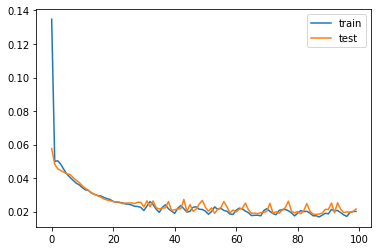

In [37]:
# split into train and test sets
values = reframed.values
number_of_days_to_train = 20
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_days_to_train * 24 * number_of_timeslots_in_one_hour

train = values[:train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], number_of_time_steps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], number_of_time_steps, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()




EVALUATE MODEL AND VISUALIZE PREDICTIONS

In [22]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
print(yhat)
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


ValueError: in user code:

    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1586 predict_function  *
        return step_function(self, iterator)
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1569 run_step  **
        outputs = model.predict_step(data)
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py:1537 predict_step
        return self(x, training=False)
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\arist\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py:214 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_1 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 39)


NON SCALED LABELS

In [32]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



dataset = generateNNdata("EHAM", timeslotLength=15, catagoricalFlightDuration=False)
dataset = dataset.set_index("timeslot")

# dataset.columns = [
#     "departing",
#     "arriving",
#     "lowcost",
#     "arrivalsFlightDuration",
#     "departuresFlightDuration",
#     "planes",
#     "weekend",
#     "winter",
#     "spring",
#     "summer",
#     "autumn",
#     "night",
#     "morning",
#     "afternoon",
#     "evening",
# 	# "arrivalsArrivalDelay",
# 	"departuresDepartureDelay"
# ]

dataset.drop(columns=['departuresArrivalDelay','arrivalsArrivalDelay'])
label = dataset.pop('departuresDepartureDelay')
dataset.insert(len(dataset.columns), 'departuresDepartureDelay', label)

# Get first month of Data
number_of_months = 1
index_slice = number_of_months * 4 * 24 * 31 - 1
dataset = dataset.iloc[0:index_slice]

# summarize first 5 rows
display(dataset)

# Normalize values
values = dataset.values
# display(values)
X, y = values[:,:-1], values[:,-1]
display(X)
display(y)
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(X)
# display(scaled)
scaled = X.concat(y)
# frame as supervised learning
number_of_time_steps = 1
number_of_outputs = 1
reframed = series_to_supervised(scaled, n_in=number_of_time_steps, n_out=number_of_outputs)
# drop columns we don't want to predict
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)  # I don't think we need this, but not sure
display(reframed)



,departing,arriving,lowcost,arrivalsFlightDuration,arrivalsDepartureDelay,arrivalsArrivalDelay,departuresFlightDuration,departuresArrivalDelay,planes,capacityFilled,weekend,winter,spring,summer,autumn,night,morning,afternoon,evening,departuresDepartureDelay
timeslot,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:15:00,1,0,1.00,0.0,0.000000,0.0,183.0,15.0,-1,0.01,0,0,1,0,0,1,0,0,0,12.0
2018-03-01 00:30:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 00:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,0,0,1,0,0,1,0,0,0,0.0
2018-03-01 01:15:00,0,1,1.00,57.0,9.000000,47.0,0.0,0.0,1,0.01,0,0,1,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-31 22:45:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:00:00,0,0,0.00,0.0,0.000000,0.0,0.0,0.0,0,0.00,1,0,1,0,0,0,0,0,1,0.0
2018-03-31 23:15:00,1,3,0.75,192.0,-7.333333,-13.0,673.0,16.0,2,0.04,1,0,1,0,0,0,0,0,1,12.0


array([[1.  , 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [1.  , 3.  , 0.75, ..., 0.  , 0.  , 1.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 1.  ],
       [1.  , 0.  , 1.  , ..., 0.  , 0.  , 1.  ]])

array([12.,  0.,  0., ..., 12.,  0., -7.])

AttributeError: 'numpy.ndarray' object has no attribute 'concat'

In [ ]:
# split into train and test sets
values = reframed.values
number_of_days_to_train = 20
number_of_timeslots_in_one_hour = 4 # 4 for 15 minute intervals, 1 for 1 hour intervals
train_index = number_of_days_to_train * 24 * number_of_timeslots_in_one_hour

train = values[:train_index, :]
test = values[train_index:, :]

print('Shape of dataset:', reframed.shape)
print('Shape of train dataset:', train.shape)
print('Shape of test dataset:', test.shape)

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], number_of_time_steps, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], number_of_time_steps, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()